# bigram LSTM

Model for predicting text sequences a bigram at a time.

In [73]:
# Modules
from __future__ import print_function
import os
import collections
import numpy as np
import random
import string
import math
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from matplotlib import pylab

## Downloading and Extracting Data

Bigrams are generated by splitting the text into non-overlapping pairs of characters.
e.g. 'abc123' -> ['ab','c1','23']

In [2]:
def get_text8(expected_bytes):
    filename = "text8.zip"
    url = "http://mattmahoney.net/dc/"
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    if os.stat(filename).st_size == expected_bytes:
        print('Found and verified')
    else:
        raise Exception('Failed to verify. Try accessing through browser.')
    return filename

def read_text(filename):
    f = zipfile.ZipFile(filename)
    for name in f.namelist():
        return tf.compat.as_str(f.read(name))
    f.close()
    return
   
expected_bytes = 31344016
filename = get_text8(expected_bytes)
text = read_text(filename)
bigrams = [text[2*i:2*i+2] for i in range(len(text)/2)]

print('Total characters: %d' % len(text))
print('Total bigrams: %d' % len(bigrams))
print('Sample text: %s' % text[:50])
print('Bigram text: %s' % bigrams[:10])

Found and verified
Total characters: 100000000
Total bigrams: 50000000
Sample text:  anarchism originated as a term of abuse first use
Bigram text: [' a', 'na', 'rc', 'hi', 'sm', ' o', 'ri', 'gi', 'na', 'te']


## Embedding Lookup for Inputs
Train a bigram-embedding via word2vec skip-gram model. 

Our embedding will map each bigram to a vector of form [x1,x2,...,xn]

Word2vec skip-gram model trains an embedding based on the context of the word; words which appear in similar contexts have similar embeddings.

#### Format dataset

In [3]:
vocabulary_size = 400

def build_dataset(bigrams):
    
    # Find counts of all bigrams
    bigram_counts = [['NA',-1]]
    most_common = collections.Counter(bigrams).most_common(vocabulary_size - 1)
    bigram_counts.extend(most_common)
    
    # Dictionary which maps a bigram to its popularity, with 0 being the most popular
    dictionary = {}
    for bigram, _ in bigram_counts:
        dictionary[bigram] = len(dictionary)
        
    # Reverse dictionary which maps popularity to a bigram
    reverse_dictionary = dict(zip(dictionary.values(),dictionary.keys()))
    
    # Data is an array storing each bigram's key in our reverse_dictionary
    # i.e. bigram[i] = reverse_dictionary[data[i]]
    data = []
    NA_count = 0
    for bigram in bigrams:
        if bigram in dictionary:
            index = dictionary[bigram]
        else:
            index = 0
            NA_count += 1
        data.append(index)
    bigram_counts[0][1] = NA_count
    
    return data, bigram_counts, dictionary, reverse_dictionary

data, bigram_counts, dictionary, reverse_dictionary = build_dataset(bigrams)
print('Most popular bigrams: ',bigram_counts[:5])
print('Reverse Dictionary: ',reverse_dictionary[5])
print('Sample Data: ', data[:10])

Most popular bigrams:  [['NA', 230382], ('e ', 1843425), (' t', 1224131), ('s ', 1111188), ('th', 990343)]
Reverse Dictionary:   a
Sample Data:  [5, 96, 220, 75, 267, 10, 56, 196, 96, 29]


#### Batch Generation

In [4]:
data_index = 0

def generate_batch(batch_size,num_skips,skip_window):
    
    # Setup
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    # Batch and labels
    batch = np.ndarray(shape=(batch_size),dtype=np.int32)
    labels = np.ndarray(shape=(batch_size,1),dtype=np.int32)
    
    # Create a buffer and add first valid span to it.
    # We use a deque with (maxlen=span). This way, when we attempt to add more elements 
    # than fit in a bigram's span, the front element will automatically be popped
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    # Fill batch and labels 
    for i in range(batch_size // num_skips):
        target = skip_window 
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            # Pick a random bigram in the span, add it to 'used' list
            while target in targets_to_avoid:
                target = random.randint(0,span - 1) 
            targets_to_avoid.append(target)
            # Add the target and the selected context-bigram to batch and labels
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        # Adjust the buffer to the next bigram's span
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    return batch, labels

data_index = 0
batch, labels = generate_batch(batch_size=8,num_skips=4,skip_window=2)
print("Batch:",[reverse_dictionary[bi] for bi in batch])
print("Labels:",[reverse_dictionary[li] for li in labels.reshape(-1)])

Batch: ['rc', 'rc', 'rc', 'rc', 'hi', 'hi', 'hi', 'hi']
Labels: ['hi', 'sm', 'na', ' a', 'rc', 'sm', ' o', 'na']


#### Tensorflow Graph

In [65]:
# Hyper params
batch_size = 500
embedding_size = 8    # Size of vector we map bigrams to
skip_window = 2       # Bigrams we consider left and right
num_skips = 4         # Times we reuse an input to generate a label

# Validation set
valid_size = 8       # Random set of words to evaluate similarity on
valid_window = 100    # Only pick dev samples in head of distribution
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64      # Negative examples to sample

# Build graph
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    
    # Input data
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # Variables
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], 
                            stddev = 1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights,softmax_biases,embed,
                                   train_labels, num_sampled, vocabulary_size))
    
    # Optimizer
    optimizer = tf.train.AdagradOptimizer(0.2).minimize(loss)
    
    # Compute minibatch-to-all embedding similarity
    # Cosine distance
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

#### Run TF Session

In [66]:
num_steps = 100001

# tensorflow session
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size,num_skips,skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 10000 == 0:
            if step > 0:
                average_loss = average_loss / 10000
            print("Avg loss step %d: %f" % (step,average_loss))
            average_loss = 0
        if step % 50000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # Nearest neighbors
                nearest = (-sim[i,:]).argsort()[1:top_k+1]
                log = 'Nearest to %s:'%valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,'%(log,close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Avg loss step 0: 4.942904
Nearest to  d: gy, ae, s , rv, ki, zi, cc, lg,
Nearest to th: un, hu, nf, ms, ab, ci, cs, le,
Nearest to  e: hs, os, gu, mp, mb, ms, ia, az,
Nearest to  b: va, bc, ab, az,  n, cs, dd, ho,
Nearest to si: rm, kh, gd, mm, dl, ju, me, ai,
Nearest to ni: ei, oo, cu, oi, rf, cr, ip, ap,
Nearest to o : oa, nf, hn, lp,  q, ci, vi, om,
Nearest to te: lk, eu, me, nu, im, nk, ec, eg,
Avg loss step 10000: 4.021156
Avg loss step 20000: 3.911892
Avg loss step 30000: 3.901801
Avg loss step 40000: 3.896075
Avg loss step 50000: 3.896986
Nearest to  d:  r,  l,  m,  b,  h,  j,  v,  g,
Nearest to th: gr, rt, pl, nn, fr, wh, sp, rp,
Nearest to  e: ws, bb, xa,  u,  s, yr,  g, ra,
Nearest to  b:  m,  l,  h,  d,  j,  r,  g,  k,
Nearest to si: fi, b , lm, mo, de, mi, di, on,
Nearest to ni: on, ti, si, iq, ci, b , lm, ax,
Nearest to o : uk, bn, v , bo, sr, do, ze,  u,
Nearest to te: ai, ie, au, pu, de, go, su, iu,
Avg loss step 60000: 3.903606
Avg loss step 70000: 3.892813


#### Embedding Visualization

In [97]:
# Use TSNE, a dimension reduction technique which attempts to preserve neighbor distances
num_points = 130
tsne = TSNE(perplexity=20, n_components=2, init='pca', n_iter=2000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

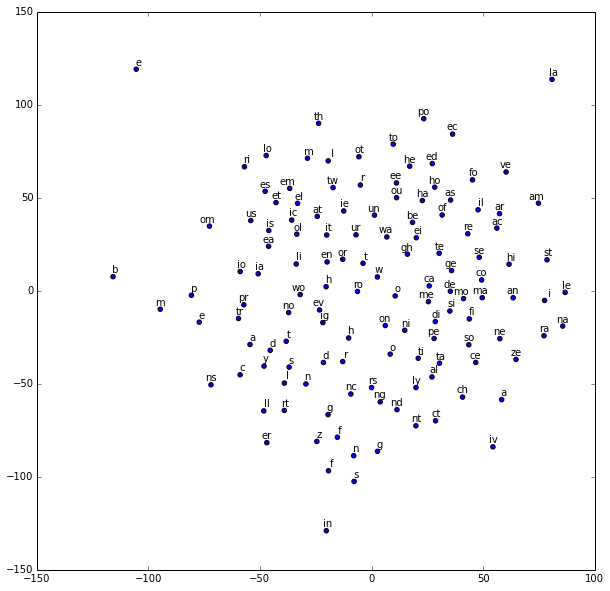

In [98]:
# Plotting function from tensorflow udacity folder
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(10,10))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

## bigram-based LSTM